### Import Some Basic Things

In [281]:
# Import Necessary Addons
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, os.path # Get directory info

# Get the list of all files in the directory
DIR = './camera_cal/'
image_names = [name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
images = []
grays = []
imgpoints = []
objpoints = []

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

### Read in all Calibration Images and Display them

./camera_cal/calibration18.jpg
./camera_cal/calibration1.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration5.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration8.jpg
./camera_cal/calibration4.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration6.jpg


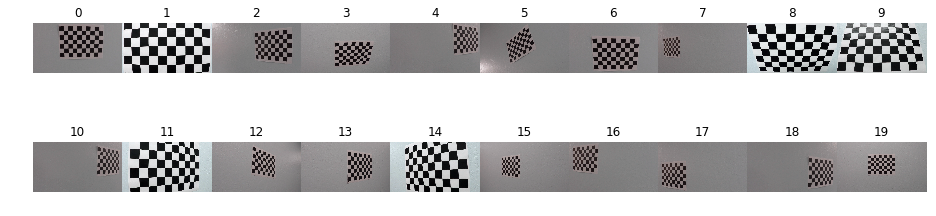

In [282]:
# Read in all images
for i in range (len(image_names)):
    filename = DIR + image_names[i]
    image = cv2.imread(DIR + image_names[i])
    images.append(image)
    grays.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    ret, corners = cv2.findChessboardCorners(grays[i], (nx, ny), None)

    
    # Add points if corners are detected
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

    print(filename)

    
# Set up subplot details
fig, axs = plt.subplots(2,10, figsize=(16, 4))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Plot all of the Calibration Images
for i in range(20):
    image = images[i]
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(i)
plt.show()

### Define Undistort Function, get Camera Matrix and print some test images

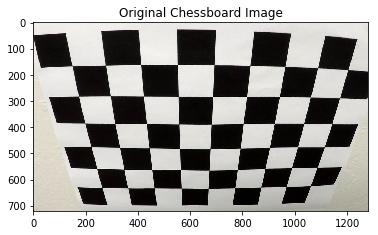

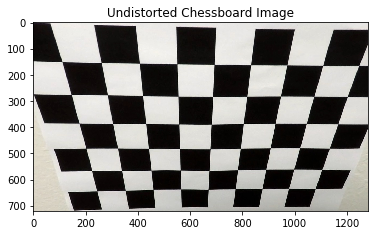

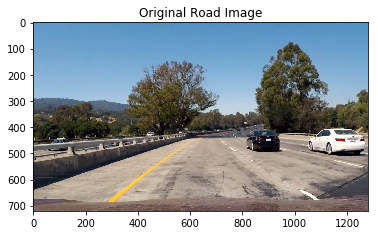

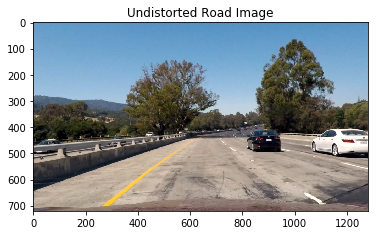

In [330]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, grays[2].shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


# Original Chessboard
plt.imshow(cv2.cvtColor(images[8], cv2.COLOR_BGR2RGB))
plt.title("Original Chessboard Image")
plt.show()

# Undistorted Chessboard
undistorted_chess = cal_undistort(images[8], objpoints, imgpoints)
plt.imshow(cv2.cvtColor(undistorted_chess, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Chessboard Image")
plt.show()

# Original Road
#original_road = cv2.imread('./test_images/straight_lines2.jpg')
original_road = cv2.imread('./test_images/test1.jpg')
plt.imshow(cv2.cvtColor(original_road, cv2.COLOR_BGR2RGB))
plt.title("Original Road Image")
plt.show()

# Undistorted Road
undistorted_road = cal_undistort(original_road, objpoints, imgpoints)
plt.imshow(cv2.cvtColor(undistorted_road, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Road Image")
plt.show()

### Use Color Transforms, Gradients, Thresholds, etc... to get a Good Binary Image

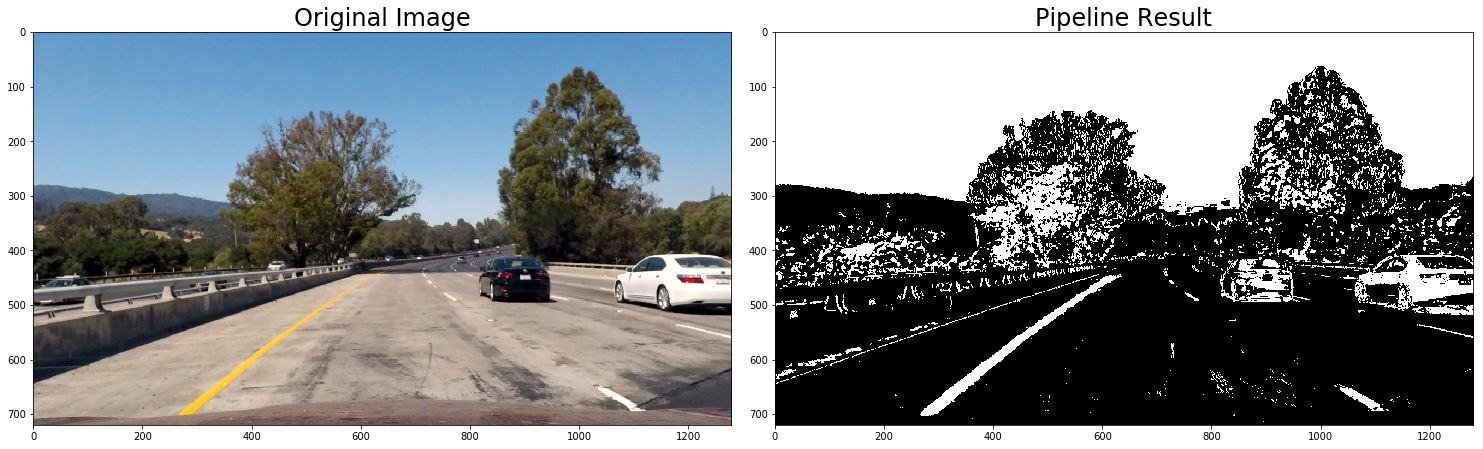

In [331]:
# Make a copy of the undistorted road test image
image = np.copy(undistorted_road)

# Function for converting BGR images to binary
def binaryImage(img, s_thresh=(90, 255), sx_thresh=(30, 150)):
    
    # Convert to HLS color space and separate the V channel
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary



binary_image = binaryImage(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
f.tight_layout()

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=24)

ax2.imshow(binary_image, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

### Draw Lines to be used for Perspective Transform

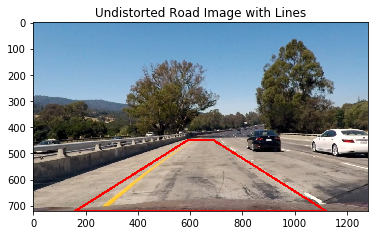

In [332]:
lined_image = np.copy(image)
lined_image = cv2.cvtColor(lined_image, cv2.COLOR_BGR2RGB)

# Draw the source points

# Source region attributes
bottom_left   = (160, 720)
top_left      = (590, 450)
top_right     = (690, 450)
bottom_right  = (1120, 720)
lineThickness = 7
line_color    = (255, 0, 0)

# Left line
cv2.line(lined_image, bottom_left, top_left, line_color, lineThickness)
# Right line
cv2.line(lined_image, bottom_right, top_right, line_color, lineThickness)
# Bottom line
cv2.line(lined_image, bottom_left, bottom_right, line_color, lineThickness)
# Top line
cv2.line(lined_image, top_left, top_right, line_color, lineThickness)


plt.imshow(lined_image, cmap='gray')
plt.title("Undistorted Road Image with Lines")
plt.show()

### Perform Perspective Transform to "bird's eye view" of Lanes

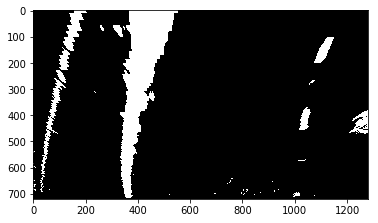

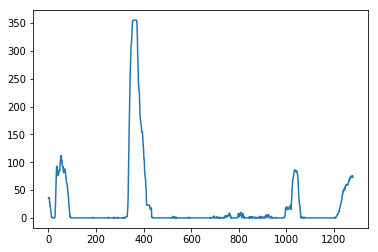

In [333]:
road_src_points = np.array([list(bottom_left), list(top_left), list(top_right), list(bottom_right)],np.float32) # Points at the start

point1 = [300,720]
point2 = [300,0]
point3 = [980,0]
point4 = [980,720]

#x = np.array([2,3,1,0])
road_dst_points = np.array([point1, point2, point3, point4],np.float32) # Points after transform

#print(road_src_points)
#print(road_dst_points)

binary_warped = np.copy(image)

img_size = (image.shape[1], image.shape[0])
M = cv2.getPerspectiveTransform(road_src_points, road_dst_points)
# Warp the image using OpenCV warpPerspective()
#binary_warped = cv2.warpPerspective(binary_image, M, img_size)

def warpImage(image, img_size, src, dst, M):
    result = cv2.warpPerspective(image, M, img_size)
    return result

# Bird's Eye Road
#plt.imshow(binary_warped, cmap='gray')
#plt.title("Warped Road Image")
test_warp = warpImage(binary_image, img_size, road_src_points, road_dst_points, M)
plt.imshow(test_warp, cmap='gray')
plt.show()

# Plot Histogram
histogram = np.sum(test_warp[test_warp.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

### Detect lane pixels and fit to find the lane boundary.

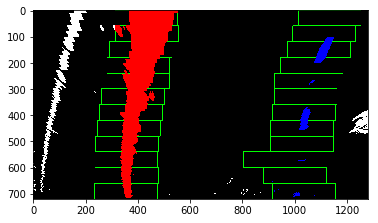

In [334]:
def detectLanes(binary_warped):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #np.sum(test_warp[test_warp.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 20
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)



    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

    #plt.show()
    
    
    result = out_img
    return result, left_fitx, right_fitx

test = np.copy(image) * 0
test, left_fitx, right_fitx = detectLanes(test_warp)
plt.imshow(test)
plt.show()

### Faster Local Search for next frame

In [335]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

### Create Road Graphics

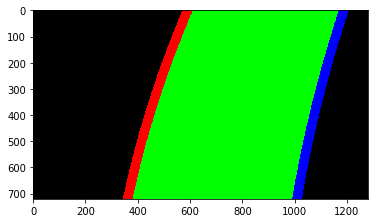

In [336]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
#out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

warp_color_overlay = np.copy(window_img * 0)

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
#cv2.fillPoly(warp_color_overlay, np.int_([pts]), (0,255, 0))

# Draw the lane onto the warped blank image
#cv2.fillPoly(image, np.int_([left_line_pts]), (255,0, 0))
#cv2.fillPoly(image, np.int_([right_line_pts]), (0,0, 255))
#cv2.polylines(warp_color_overlay, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=35)
#cv2.polylines(warp_color_overlay, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=35)
#cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,255, 255))
warp_color_overlay = cv2.addWeighted(warp_color_overlay, 1, warp_color_overlay, 0.3, 0)
#plt.imshow(warp_color_overlay)
#plt.plot(left_fitx, ploty, color='yellow')
#plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
#plt.show()

def colorRoad(image, left_fitx, right_fitx):
    # Creat black convas
    warp_color_overlay = np.copy(image * 0)
    
    ploty = np.linspace(0, warp_color_overlay.shape[0]-1, warp_color_overlay.shape[0])
    pts_left = 0
    pts_right = 0
    # Create the left and right drawing areas
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    # Middle Area
    pts = 0
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(warp_color_overlay, np.int_([pts]), (0,255, 0))
    
    cv2.polylines(warp_color_overlay, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=35)
    cv2.polylines(warp_color_overlay, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=35)
    #warp_color_overlay = cv2.addWeighted(warp_color_overlay, 1, warp_color_overlay, 0.3, 0)
    result = warp_color_overlay
    
    return result
    
thing = colorRoad(image, left_fitx, right_fitx)
plt.imshow(thing)
plt.show()

### Reverse Transform Back to Road Surface

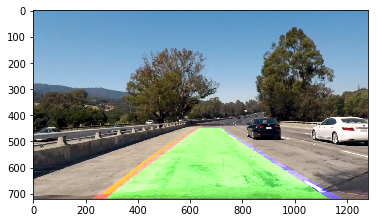

In [337]:
image = cv2.cvtColor(undistorted_road, cv2.COLOR_BGR2RGB)

color_overlay = np.copy(warp_color_overlay*0)

img_size = (image.shape[1], image.shape[0])
M = cv2.getPerspectiveTransform(road_dst_points, road_src_points)
# Warp the image using OpenCV warpPerspective()
color_overlay = cv2.warpPerspective(warp_color_overlay, M, img_size)

#result = cv2.addWeighted(image, 1, color_overlay, 0.5, 0)
#plt.figure(figsize=(16,16))
#plt.imshow(result, cmap='gray')
#plt.title("Warped Road Image")


# Tranform and overlay on road function
def transToRoad(image, warped_color_overlay, M):
    img_size = (image.shape[1], image.shape[0])
    #print(img_size)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    color_overlay = cv2.warpPerspective(warped_color_overlay, M, img_size)
    result = cv2.addWeighted(image, 1, color_overlay, 0.5, 0)
    return result

test_final = np.copy(image) * 0
test_final = transToRoad(image, thing, M)
plt.imshow(test_final)
plt.show()

### Define full image processing pipeline

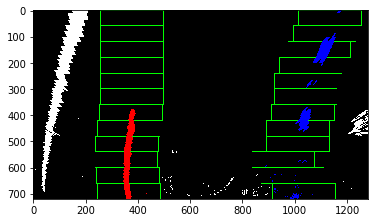

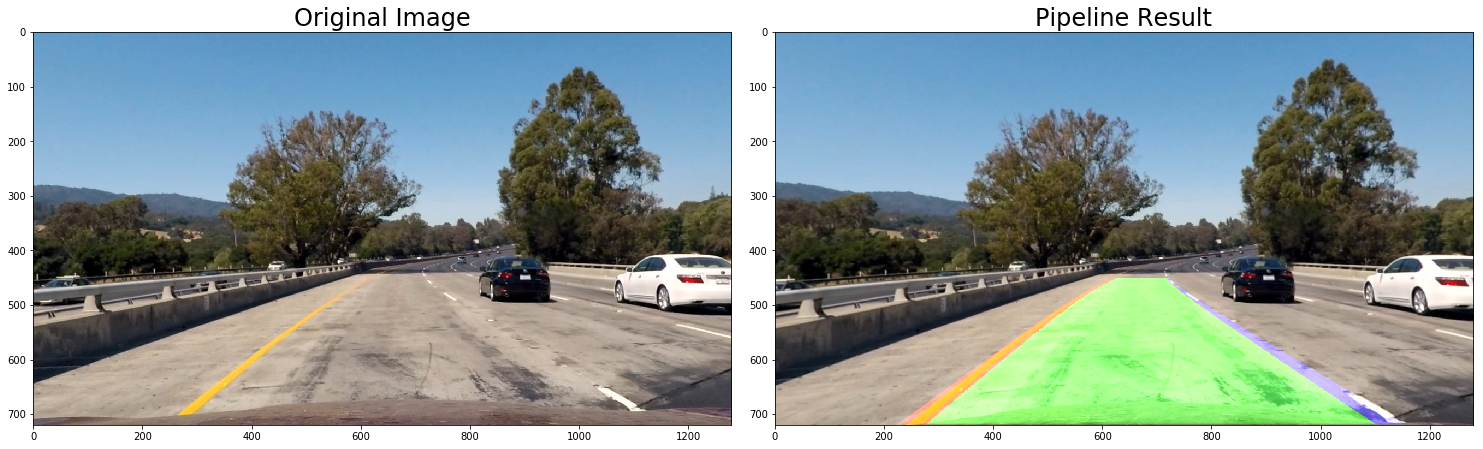

In [338]:
def process_image(image):
    src = np.array([list(bottom_left), list(top_left), list(top_right), list(bottom_right)],np.float32) # Points at the start
    point1 = [300,720]
    point2 = [300,0]
    point3 = [980,0]
    point4 = [980,720]
    dst = np.array([point1, point2, point3, point4],np.float32) # Points after transform
    img_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    
    
    
    undistort = cal_undistort(image, objpoints, imgpoints)
    
    binary = binaryImage(undistort, (170, 255), (20, 100))
    
    binary_warped = warpImage(binary, img_size, src, dst, M)
    
    lanes, left_fitx, right_fitx = detectLanes(binary_warped)
    
    warped_color = colorRoad(lanes, left_fitx, right_fitx)
    
    RM = cv2.getPerspectiveTransform(dst, src) # Reverse transform matrix
    colored_road = transToRoad(undistort, warped_color, RM)
    
    #result = cv2.cvtColor(warped,cv2.COLOR_GRAY2RGB) * 255
    return colored_road

#cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

pipeline_test = process_image(image)
#plt.imshow(image)
#plt.imshow(test2, cmap='gray')
#plt.title("Warped Road Image")
#plt.show()

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=24)

ax2.imshow(pipeline_test, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

### Process Video Through Pipeline

In [340]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import *


video_output = './output_images/project_video_test.mp4'

video_clip = VideoFileClip('./project_video.mp4')

#video_clip = video.fl_image(process_image).subclip(0,5) #NOTE: this function expects color images!!
video_clip = video.fl_image(process_image)

#mywriter = animation.FFMpegWriter()
#anim.save(video_output,writer=mywriter)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video_test.mp4
[MoviePy] Writing video ./output_images/project_video_test.mp4


100%|█████████▉| 1260/1261 [12:22<00:00,  1.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_test.mp4 

CPU times: user 18min 39s, sys: 11.5 s, total: 18min 51s
Wall time: 12min 23s
